# (실습 5-3) BART 기반 자연언어처리 실습



## 문서요약 Task로 BART fine-tuning하기
- 전체 문서의 내용을 입력으로 줬을때, `생성 요약문 작성`
- 법률 문서 : 법원 판결문 뉴스 텍스트 및 법원 주요 판결문 텍스트

### ✨ 실습 개요 <br>

1) 실습 목적 <br>
- 이번 실습에서는 BART 모델을 PyTorch를 사용하여 fine tuning 해봅니다.
- BART 모델은 encoder-decoder 구조를 통해, 자연어 처리에서 뛰어난 성능을 보여주는 모델로 이 구조와 작동 방식을 이해하고, downstream task 에서 fine-tuning 하는 방법을 확인해봅니다

</font></b>

2) 수강 목표 <br>
  * BART 모델의 구조와 fine-tuning 방법을 이해한다
  * BART 모델을 문서 요약을 위한 모델로 fine-tuning하고, 학습 과정에서 일어나는 연산과 input/output 형태에 대해 이해한다
  * BART 모델을 원하는 downstream task로 tuning 하여 사용할 수 있다





#### 실습 목차

1. Dataset & Tokenizing
  * 1-1. summ_dataset class 정의
  * 1-2. load_Data, tokenized_dataset 함수 정의
  * 1-3. prepare_dataset 함수 정의
2. Model & Trainer
  * 2-1. compute_metrics 함수 정의 (rouge)
  * 2-2. load_tokenizer_and_model_for_train 함수 정의
  * 2-3. load_trainer_for_train 함수 정의
  * 2-4. train 함수 정의
  * 2-5. arguments 지정 및 학습 진행
3. Inference & Evaluation
  * 3-1. load_model_for_inference 함수 정의
  * 3-2. inference 함수 정의
  * 3-3. infer_and_eval 함수 정의

### ⚙️ 데이터 및 환경설정
- fine tuning 할 학습(train) 데이터와 평가(test) 데이터를 불러옵니다.
- 베이스라인에 필요한 라이브러리들을 설치합니다.
- 런타임 유형을 GPU로 설정합니다.

###### 1. 데이터 다운로드

- 아래코드 실행후 좌측 "파일" Tab 내 train.csv , test.csv 확인하기

In [1]:
import os 
os.chdir('/data/ephemeral/home/')
home_dir = '/data/ephemeral/home/'

In [3]:
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv' -O train.csv
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1wMhyqoJ0D7xQepW4y7Ireq2U2X61ndYz' -O test.csv

--2025-08-02 07:31:17--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2025-08-02 07:31:17--  https://docs.google.com/uc?export=download&id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv
Resolving docs.google.com (docs.google.com)... 142.250.197.14, 2404:6800:4005:81e::200e
Connecting to docs.google.com (docs.google.com)|142.250.197.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv&export=download [following]
--2025-08-02 07:31:19--  https://drive.usercontent.google.com/download?id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.197.129, 2404:6800:4005:822::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.

[참고용]
- 원본 데이터 링크 : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=97
- 데이터셋 분리 코드 : https://colab.research.google.com/drive/1R1sioDOOAMpUASkadBbGnPL6ZuBKdGf9?usp=sharing
- 데이터셋 저장 드라이브 : https://drive.google.com/drive/folders/1M3BUMRIN4o1EFceKtJowfIvNhet_Fsbb?usp=sharing

###### 환경설정



```
pytorch_lightning
torch
pandas
numpy
transformers
sklearn
evaluate
```
- 코랩에서는 pytorch_lightning과 transformers 만 설치


In [ ]:
# !pip install pytorch_lightning
# !pip install transformers
# !pip install transformers[torch]
# !pip install evaluate
# !pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Preparing metadata 

- "런타임" > "런타임유형변경" > "Python3, T4 GPU" 선택해준 후, "런타임재실행"해줍니다.

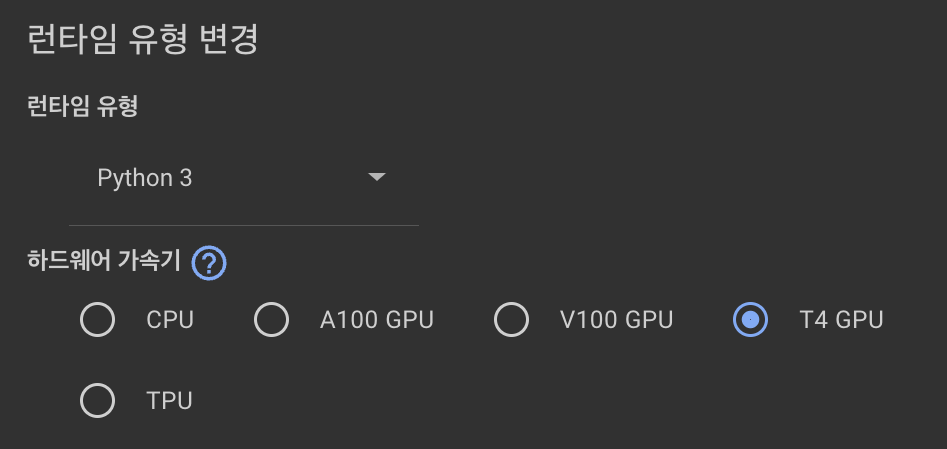

In [1]:
import torch
torch.cuda.is_available() # GPU 할당여부 확인

True

### 1️⃣ Dataset & Tokenizing
- torch.utils.data.Dataset class 를 상속받아 summ_dataset class를 정의해줍니다.
- 데이터를 불러오는 load_data 와 tokenizing을 진행하는 <br> tokenized_dataset 를 정의해줍니다.
-  위에서 정의된 함수들을 활용하여, 데이터셋을 불러와 tokenizing 한후에, <br> torch dataset class로 변환해줍니다.
- 이후 train data /validation data 는 7.5 : 2.5로 나눠줍니다.

####1-1. <b> summ_dataset class </b> 정의

In [42]:
import os
import pandas as pd
import torch

class summ_dataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, summ_dataset, tokenizer):
      self.dataset = summ_dataset
      self.tokenizer = tokenizer

    def __getitem__(self,idx):
      input_ids = self.dataset['input_ids'][idx]

      # 추론용 데이터셋인 경우 {"input_ids":[[tokens]...], "labels": None} 임.
      labels = self.dataset['labels'] ### 문제의 코드
      if labels is not None:
          labels = labels[idx]
      else: # None 인 경우
          labels = None

      # attention_mask를 생성 > attention_mask는 DataCollator가 자동으로 생성.
      # attention_mask = input_ids.ne(self.tokenizer.pad_token_id)
      return dict(input_ids=input_ids, labels=labels)
        # input_ids=torch.tensor(self.dataset["input_ids"][idx])
        # labels=torch.tensor(self.dataset["labels"][idx])
        # attention_mask=input_ids.ne(self.tokenizer.pad_token_id)

        # return dict(input_ids=input_ids,
        #             labels=labels,
        #             attention_mask=attention_mask)

    def __len__(self):
        return len(self.dataset["input_ids"])

####1-2. <b>load_data , construct_tokenized_dataset</b> 함수 정의
- "데이터를 불러오고" "토크나이징 해주는" 함수들

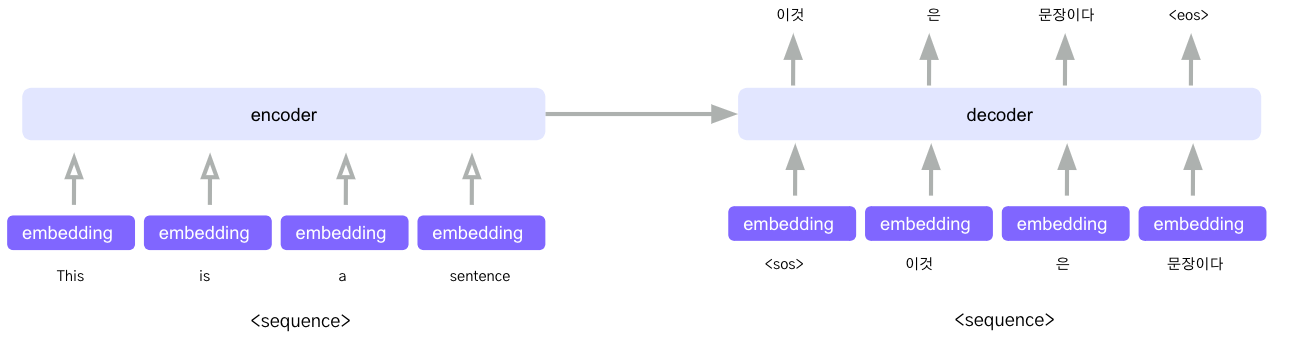

In [29]:
def load_data(dataset_dir):
    """csv file을 dataframe으로 load"""
    dataset = pd.read_csv(dataset_dir)
    return dataset

def tokenized_dataset(dataset, tokenizer, doc_max_length, sum_max_len):
    """ 데이터 토크나이징"""
    document_text = dataset['document']
    summ_text = dataset['summary']
    # document 를 tokenizing (d_1 d_2 d_3 ... d_n)
    tokenized_senetences = [tokenizer(documents, 
        # padding = 'max_length', 
        truncation=True, max_length=doc_max_length, add_special_tokens=True)['input_ids'] for documents in document_text.values
    ]

    # summary 를 tokenizing (s_1 s_2 s_3 ... s_m <eos>)
    summary = [
        tokenizer(summaries + tokenizer.eos_token, 
            # padding = 'max_length',
        truncation=True, max_length=sum_max_len, add_special_tokens=True)['input_ids'] for summaries in summ_text.values
    ]
    # padding 된 부분이 학습되지 않도록 -100 으로 치환
    labels = [[-100 if token == tokenizer.pad_token_id else token for token in l] for l in summary]
    out = {"input_ids": tokenized_senetences, "labels": labels}

    print("tokenizing 된 데이터 형태")
    print(tokenizer.convert_ids_to_tokens(tokenized_senetences[-1]))
    print("label의 형태")
    print(labels[-1])
    return out

#### 모델에 들어가는 입력 설명

BART를 학습하기 위해서는 세 가지가 필요합니다. Encoder Input, Decoder Input, Decoder Label 입니다. 코드 상에서는 그 중 두 가지 (Encoder Input, Decoder Label)를 만들어서 모델에 넣었습니다.
  1. Encoder Input
    - 위 예시에서는 "This is a sentence".
    - 코드 상에서는 out의 input_ids가 Encoder Input으로 들어가게 됩니다.
  2. Decoder Label
    - 위 예시에서는 "이것 은 문장이다 \<eos>".
    - 코드 상에서는 out의 labels가 Decoder Label로 들어가게 됩니다.

**Q. Decoder Input은 만들지 않아도 되나요?**

**A. Decoder Input은 모델 내부에서 자동적으로 만들기 때문에, 코드 상에서 만들어서 넣을 필요가 없습니다.**
- 위 예시에서는 "\<sos> 이것 은 문장이다".
- 하지만 코드 상에서는 따로 만들지 않았습니다.
- 그 이유는 transformer에서 BART 구현을 보면 (아래 링크 참고),  decoder_input_ids가 없는 경우, 입력으로 들어온 Decoder Label을 right shift 합니다.
- right shift는 Label의 맨 뒤 \<eos>를 없애고, 맨 앞에 \<sos>를 추가하는 작업입니다.
- 그 결과, "이것 은 문장이다 \<eos>" 의 Decoder Label이, "\<sos> 이것 은 문장이다"로 변경됩니다.

참고 링크 : https://github.com/huggingface/transformers/blob/main/src/transformers/models/bart/modeling_bart.py#L1573

####1-3. prepare_dataset 함수 정의
- 앞서 정의한 함수들 기반으로 데이터셋 준비하는 함수

🌟 전처리과정 🌟<blockquote>
1. train.csv / test.csv 파일을 pd.dataframe 로 다운로드 해준다. <br>
2. train/validation set을 나눠준다. (7.5:2.5) <br>
3. 전체 문서와 요약 데이터를 모두 tokenizing 해준다.  <br>
4. 요약(label) 데이터는 Padding 된 부분은 loss 가 흐르지 않도록 -100 으로 치환해준다. <br>
5. tokenizing 된 데이터를 summ_dataset class로 반환해준다. <br>

In [30]:
from torch.utils.data import DataLoader

def prepare_dataset(dataset_dir, tokenizer,doc_max_len, sum_max_len):
    """학습(train)과 평가(test)를 위한 데이터셋을 준비"""
    # load_data
    print("dataset_dir:", dataset_dir)
    if isinstance(dataset_dir, tuple):
        dataset_dir = dataset_dir[0]
    train_file_path = os.path.join(dataset_dir, "train.csv")
    train_dataset = load_data(train_file_path)
    test_dataset = load_data(os.path.join(dataset_dir, "test.csv"))

    # split train / validation = 7.5 : 2.5
    train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.25,random_state=42)

    ### tokenizer 에 들어가기 전 데이터 형태
    print("tokenizer 에 들어가는 데이터 형태")
    print(train_dataset.iloc[0])

    # tokenizing
    print("train tokenizing...")
    tokenized_train =tokenized_dataset(train_dataset, tokenizer,  doc_max_len, sum_max_len)
    print("valid tokenizing...")
    tokenized_val =tokenized_dataset(val_dataset, tokenizer, doc_max_len, sum_max_len)
    print("test tokenizing...")
    tokenized_test =tokenized_dataset(test_dataset, tokenizer, doc_max_len, sum_max_len)

    # make dataset for pytorch.
    summ_train_dataset = summ_dataset(tokenized_train, tokenizer)
    summ_val_dataset = summ_dataset(tokenized_val, tokenizer)
    summ_test_dataset = summ_dataset(tokenized_test, tokenizer)
    print("--- dataset class Done ---")

    return summ_train_dataset , summ_val_dataset, summ_test_dataset , test_dataset


### 2️⃣ Model & Trainer
- huggingface 에서 사전학습된(pre-trained) 모델을 불러옵니다.
- huggingface 의 Trainer 모듈을 정의하고 학습에 사용될 Arguments 들을 지정해줍니다.

In [32]:
import os
import random
import numpy as np
import pytorch_lightning as pl
import torch
#from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    BartForConditionalGeneration
)
from transformers import Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import EarlyStoppingCallback, DataCollatorForSeq2Seq
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup
import evaluate
from rouge_score import rouge_scorer, scoring
import datasets

####2-1. compute_metrics 함수 정의
- 학습 중 validation 할때 사용될 평가지표 정의하는 함수
- 해당 실습에서는 Rouge Score를 Metric으로 사용

Q. Rouge Score 란?
문서 요약, 기계 번역 등의 task 에서 모델이 생성한 문장을 평가하기 위한 지표
다양한 종류의 score 가 있지만, 이 중 ROUGE-N의 F1-score(recall 과 precisiond을 반영)를 사용합니다.
- ROUGE-N : N gram에 기반하여, 모델이 생성한 요약문과 정답 요약문 중 겹치는 단어의 개수를 확인하여 생성한 요약문을 평가하는 평가지표
- ROUGE-N recall : 두 요약문 중 겹치는 N-gram의 수 / 정답 요약문의 N-gram의 수
- ROUGE-N precision : 두 요약문 중 겹치는 N-gram의 수 / 모델이 생성한 요약문의 N-gram의 수  

예) ROUGE-1 에서, 모델이 생성한 요약문(R) : "the hello a cat dog fox jumps"/ 정답 요약문 (T) : "the fox jumps" 인 경우를 가정.
- 두 요약문 중 겹치는 1-gram ['the', 'fox', 'jumps'] 이므로 ROUGE-1 recall 은 3/3, ROUGE-1 precision 은 3/7 = 0.43

In [33]:
import torch.nn.functional as F
import rouge_score
import re
# ['[BOS]', '[EOS]', '[UNK]', '[SEP]', '[PAD]', '<s>', '[MASK]']
def remove_origin_special_tokens(decoded_preds, decoded_labels):
    remove_tokens = ['[BOS]', '[EOS]', '[UNK]', '[SEP]', '[PAD]', '<s>', '[MASK]']
    replaced_predictions = list(decoded_preds)
    replaced_labels = list(decoded_labels)
    for token in remove_tokens:
        replaced_predictions = [sentence.replace(token, " ") for sentence in replaced_predictions]
        replaced_labels = [sentence.replace(token, " ") for sentence in replaced_labels]
    replaced_predictions = [re.sub(r'\s+', ' ', sentence) for sentence in replaced_predictions]
    replaced_labels = [re.sub(r'\s+', ' ', sentence)  for sentence in replaced_labels]  
    return replaced_predictions, replaced_labels      

def compute_metrics(pred, tokenizer):
    # tokenizer load
    MODEL_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # 예측, 정답 비교
    preds, labels = pred
    if isinstance(preds, tuple):
      preds = preds[0]

    # 생성된 summary 를 decode
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)
    decoded_preds = tokenizer.batch_decode(preds.argmax(-1), skip_special_tokens=False)
    decoded_preds, decoded_labels = remove_origin_special_tokens(decoded_preds, decoded_labels)
    
    retokenized_preds = [" ".join(tokenizer.tokenize(sentence)) for sentence in decoded_preds]
    retokenized_labels = [" ".join(tokenizer.tokenize(sentence)) for sentence in decoded_labels]

    # rouge score 계산
    # 토큰 기준 Rouge 점수 계산.
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False) # 한국어 특성 상 stemmer 사용 안 함.
    scores = [scorer.score(label, pred) for label, pred in zip(retokenized_labels, retokenized_preds)]
    
    # 평균 f-점수를 계산하고 반환합니다.
    avg_scores = {}
    for key in ['rouge1', 'rouge2', 'rougeL']:
        avg_scores[key] = np.mean([s[key].fmeasure for s in scores])
    
    result = {key.replace('rouge', 'rouge-'): value for key, value in avg_scores.items()}
    result['rouge-mean'] = np.mean(list(result.values()))
    return result

    # metric = datasets.load_metric("rouge")
    # result = metric.compute(
    #     predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    # )
    # # ROUGE 결과를 추출
    # result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # result = {k: round(v, 4) for k, v in result.items()}

    # return {
    #     'Rouge-2' : result['rouge2']
    #     }

####2-2.load_tokenizer_and_model_for_train 함수 정의
- 학습에 사용될 토크나이저와 모델을 불러오는 함수

In [34]:
def load_tokenizer_and_model_for_train():
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    # model과 tokenizer를 load
    MODEL_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # model의 hyperparameter를 setting
    model_config = AutoConfig.from_pretrained(MODEL_NAME)
    print(model_config)

    model = AutoModelForSeq2SeqLM.from_pretrained(
        MODEL_NAME, config=model_config
    )
    print("--- Modeling Done ---")
    return tokenizer , model

####2-3.load_trainer_for_train 함수 정의
- 학습에 사용될 Trainer 모듈을 정의하고 Arguments들을 지정해준다.
- BART 모델은 encoder-decoder 모델(seq2seq)이기 때문에, Seq2SeqTrainingArguments 와 Seq2SeqTrainer 을 사용한다.

In [ ]:
def load_trainer_for_train(model,summ_train_dataset,summ_val_dataset, tokenizer):
    """학습(train)을 위한 huggingface trainer 설정"""
    # 변경 : TrainingArguments > Seq2SeqTrainingArguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=args.save_path + "results",  # output directory
        save_total_limit=args.save_limit,  # number of total save model.
        save_steps=args.save_step,  # model saving step.
        num_train_epochs=args.epochs,  # total number of training epochs
        learning_rate=args.lr,  # learning_rate
        per_device_train_batch_size=args.batch_size,  # batch size per device during training
        per_device_eval_batch_size=4,  # batch size for evaluation
        warmup_steps=args.warmup_steps,  # number of warmup steps for learning rate scheduler
        weight_decay=args.weight_decay,  # strength of weight decay
        logging_dir=args.save_path + "logs",  # directory for storing logs
        logging_steps=args.logging_steps,  # log saving step.
        eval_strategy="steps",  # evaluation strategy to adopt during training
            # `no`: No evaluation during training.
            # `steps`: Evaluate every `eval_steps`.
            # `epoch`: Evaluate every end of epoch.
        eval_steps=args.eval_steps,  # evaluation step.
        load_best_model_at_end=True,
        #predict_with_generate=True
        report_to='none'
    )

    ## Add callback & optimizer & scheduler
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=5, early_stopping_threshold=0.001
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.lr,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.weight_decay,
        amsgrad=False,
    )
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        # BART 모델의 차원 불일치 문제를 해결하기 위해 label_pad_token_id를 -100으로 명시합니다.
        # label_pad_token_id=-100,
        # decoder_start_token_id=generate_model.config.decoder_start_token_id # 디코더의 시작 토큰 ID를 모델의 tokenizer에 맞게 명시합니다.
    )
    print("--- Set training arguments Done ---")

    # 변경 : Trainer > Seq2SeqTrainer
    trainer = Seq2SeqTrainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        args=training_args,  # training arguments, defined above
        train_dataset=summ_train_dataset,  # training dataset
        eval_dataset=summ_val_dataset,  # evaluation dataset
        compute_metrics=lambda pred: compute_metrics(pred, tokenizer),  # define metrics function
        data_collator=data_collator,
        callbacks=[MyCallback],
        optimizers=(
            optimizer,
            get_cosine_with_hard_restarts_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=args.warmup_steps,
                    num_training_steps=len(summ_train_dataset) * args.epochs,
            ),
        ),
    )
    print("--- Set Trainer Done ---")

    return trainer


####2-4.train 함수 정의
- 실험세팅 후 앞서 정의한 함수들 활용하여 학습을 진행하는 함수

🌟 학습동작과정 🌟
<blockquote>
1. 실험에 영향을 주는 모든 seed를 고정해준다. <br>
2. 사용할 gpu를 device에 할당해준다. <br>
3. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
4. 학습에 사용될 summ_dataset 을 불러온다.<br>
5. 학습에 사용될 Trainer 를 불러온다.<br>
6. 학습을 진행한후에 best_model을 저장해준다. <br>

In [39]:
def train():
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer , model = load_tokenizer_and_model_for_train()
    model.to(device)

    # set data
    summ_train_dataset, summ_val_dataset, summ_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,tokenizer,args.doc_max_len,args.sum_max_len)
    # set trainer
    trainer = load_trainer_for_train(model,summ_train_dataset,summ_val_dataset, tokenizer)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    # model.save_pretrained("./best_model")


####2-5.arguments 지정 및 학습 진행

In [40]:
torch.cuda.empty_cache()

In [43]:
class args():
    """학습(train)과 추론(infer)에 사용되는 arguments 관리하는 class"""
    dataset_dir = '/data/ephemeral/home',
    model_type = "bart" # 다른 모델 사용 가능 e.g) "bert" , "electra" ...
    model_name = "cosmoquester/bart-ko-base"
    save_path = "./"
    save_step = 400
    logging_steps = 200
    eval_steps = 200
    save_limit = 5
    seed = 42
    epochs = 20 # 10
    batch_size = 4 # 메모리 상황에 맞게 조절 e.g) 16 or 32
    doc_max_len = 256
    sum_max_len = 128
    lr = 3e-5
    weight_decay = 0.01
    warmup_steps = 5
    scheduler = "linear"
    model_dir = "./best_model" #추론 시, 저장된 모델 불러오는 경로 설정
train()


Seed set to 42


device: cuda:0
BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 2,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 3,
  "forced_eos_token_id": 3,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 2048,
  "model_type": "bart",
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "scale_embedding": false,
  "torch_dtype": "float32",
  "transformers_version": "4.54.

tokenizing 된 데이터 형태
['▁행정', '행위', '(', '과', '세', '처', '분', ')', '의', '▁취소', '처', '분', '의', '▁위법', '이', '▁중대', '하고', '명', '백', '하여', '▁당연', '무', '효', '이', '거나', ',', '그', '▁취소', '처', '분', '에', '▁대', '하여', '▁소원', '▁또는', '▁행정소송', '으로', '▁다', '툴', '▁수', '▁있', '는', '▁명문', '규', '정', '이', '▁있', '는', '▁경우', '는', '▁별', '론', ',', '행정', '행위', '의', '▁취소', '처', '분', '의', '▁취소', '에', '▁의', '하여', '▁이미', '▁효력', '을', '▁상실', '한', '▁행정', '행위', '를', '▁소생', '시', '킬', '▁수', '▁없', '고', ',', '그러', '기', '▁위', '하여', '는', '▁원', '▁행정', '행위', '와', '▁동일', '내', '용', '의', '▁행정', '행위', '를', '▁다시', '▁행', '할', '▁수', '밖', '에', '▁없', '다', '.']
label의 형태
[1743, 14490, 858, 2317, 2937, 2143, 189, 1709, 1258, 4640, 189, 7492, 40, 1324, 139, 4929, 28654, 19418, 23, 20859, 55, 28, 1208, 8122, 2448, 753, 189, 28, 1208, 224, 1208, 613, 1534, 19418, 1114, 3823, 1743, 14490, 858, 2317, 2937, 2143, 858, 2317, 615, 1942, 546, 7930, 2791, 1353, 1070, 1743, 14490, 2538, 14026, 425, 15172, 55, 66, 483, 173, 227, 274, 4929, 1208, 140, 1

Step,Training Loss,Validation Loss


TypeError: compute_metrics() missing 1 required positional argument: 'tokenizer'

### 3️⃣ Inference & Evaluation
- 학습완료된(fine-tuned) 모델을 불러와서 추론(infer)을 진행합니다.
- 추론된 예측값들과 정답값을 비교하여 평가(evaluation)합니다.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

####3-1.load_model_for_inference 함수 정의
- 학습된(fine-tuned) 모델의 체크포인트(checkpoint)를 불러오는 함수 <br>
<b>(이때, 토크나이저는 기존과 동일하게 huggingface 에서 불러온다. )</b>


In [ ]:
def load_model_for_inference():
    """추론(infer)에 필요한 모델과 토크나이저 load """
    # load tokenizer
    Tokenizer_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

    ## load my model
    model = AutoModelForSeq2SeqLM.from_pretrained(args.model_dir)

    return tokenizer, model

####3-2. inference 함수 정의
- 학습된(fine-tuned)모델을 통해 평가 데이터의 예측값 추론해내는 함수

🌟 추론(infer) 계산과정 🌟

<blockquote>
1. model.eval , torh.no_grad 를 통해 모델을 추론 모드로 변경 <br>
2. 모델에 입력값으로 input_ids 를 <b>gpu에 할당한 후</b> 입력으로 주고 결과값(outputs) 생성 (generate) <br>
3. 결과값(outputs) 이 요약문이므로, 다시 decode 하여 예측 레이블(label) 생성 <br>
4. 생성된 레이블(label) 을 concat 하여 리스트 형태로 반환

In [ ]:
def inference(model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    MODEL_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    dataloader = DataLoader(tokenized_sent, batch_size=args.batch_size, shuffle=False)
    model.eval()
    output_pred = []

    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model.generate(
                input_ids=data["input_ids"].to(device), # Encoder Input
                decoder_start_token_id=tokenizer.bos_token_id, # Decoder Input으로 들어가는 <bos> 토큰 아이디 지정
                max_length=128,
            )
        # decode
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        output_pred.append(decoded_preds)
    return (np.concatenate(output_pred).tolist(),)


####3-3.infer_and_eval 함수 정의
- 학습된(fine-tuned) 모델로 추론(infer)한 후 예측한 결과를 평가(evaluation)하는 함수

<blockquote>
1. 사용할 gpu를 device에 할당해준다. <br>
2. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
3. 추론에 사용될 summ_dataset 을 불러온다.<br>
4. model 과 summ_dataset을 입력으로 주고 추론(infer)을 진행한다. <br>
5. test data 의 레이블(label)과 예측값(pred)을 비교하여 평가지표를 계산한다.<br>
6. 최종 예측값을 csv 형태로 저장해준다. <br>

In [ ]:
def infer_and_eval():
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    tokenizer, model = load_model_for_inference()
    model.to(device)

    # set data
    summ_train_dataset, summ_val_dataset, summ_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,tokenizer,args.doc_max_len,args.sum_max_len)
    # predict answer
    pred_answer = inference(model, summ_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    # evaluate between label and prediction
    labels = test_dataset['summary'].values
    pred = pred_answer[0]

    metric = datasets.load_metric("rouge")
    # 전체 데이터에 대한 값 계산
    result = metric.compute(predictions=pred, references=labels, use_aggregator = True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f" ----- rouge :{result['rouge2']} -----")


    # 각각 데이터에 대한 값 계산
    pred_scores = metric.compute(predictions=pred, references=labels, use_aggregator = False)
    pred_score = [score.fmeasure * 100 for score in pred_scores['rouge2']]


    # make csv file with predicted answer
    output = pd.DataFrame(
        {
            "document": test_dataset["document"],
            "summary_pred": pred,
            "summary_label": labels,
            "score" : pred_score
        }
    )

    # 최종적으로 완성된 예측한 라벨 csv 파일 형태로 저장.
    result_path = "./prediction/"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(
        os.path.join(result_path,"result.csv"), index=False
    )
    print("--- Save result ---")
    return output

In [ ]:
output_df = infer_and_eval()
output_df.head(10)

tokenizer 에 들어가는 데이터 형태
document    이름 때문에 병을 앓는다는 것은 비과학적이고비합리적인 견해로서 개명신청의 정당한 이...
summary     이름 때문에 병을 앓는다는 것은 비과학적이고 비합리적 견해로서 개명신청의 정당한 이...
Name: 227, dtype: object
train tokenizing...
tokenizing 된 데이터 형태
['소', '멸', '시', '효', '의', '▁기', '산', '일', '은', '▁채무', '의', '▁소멸', '이', '라고', '▁하', '는', '▁법률', '효', '과', '▁발생', '의', '▁요건', '에', '▁해당', '하', '는', '▁소멸', '시', '효', '▁기간', '▁계산', '의', '▁시발점', '으로', '서', '▁소멸', '시', '효', '▁항변', '의', '▁법률', '요', '건', '을', '▁구성', '하', '는', '▁구체', '적', '인', '▁사실', '에', '▁해당', '하', '므로', '▁이', '는', '▁변론', '주의', '의', '▁적용', '▁대상', '이', '고', ',', '따', '라', '서', '▁본래', '의', '▁소멸', '시', '효', '▁기', '산', '일', '과', '▁당사자', '가', '▁주장', '하', '는', '▁기', '산', '일', '이', '▁서로', '▁다른', '▁경우', '에', '는', '▁변론', '주의', '의', '▁원칙', '상', '▁법원', '은', '▁당사자', '가', '▁주장', '하', '는', '▁기', '산', '일', '을', '▁기준', '으로', '▁소멸', '시', '효', '를', '▁계산', '하여', '야', '▁하', '는데', ',', '이', '는', '▁당사자', '가', '▁본래', '의', '▁기', '산', '일보', '다', '▁뒤', '의', '▁날짜', '를', '▁기', '산', '일', '로', '▁

100%|██████████| 125/125 [05:53<00:00,  2.83s/it]


--- Prediction done ---
 ----- rouge :8.7368 -----
--- Save result ---


,document,summary_pred,summary_label,score
0,[1] 가처분은 가처분 채무자에 대한 부작위 명령을 집행하는 것이므로가처분의 채무자...,구 지방세법시행령 제182조의2 제1항 제3호는 지방세법시행령 제1호의 규정에 의한...,가처분은 가처분 채무자에 대한 부작위 명령을 집행하는 것이므로 가처분의 채무자가 아...,0.0
1,구 토지개량사업법 제129조의 규정에 의하면환지인가의 고시가 있은 후에는 환지확정등...,토지개량사업법 제129조의 규정에 의하면 환지인가의 고시가 있은 후 환지확정등기가 ...,환지인가의 고시가 있은 후에는 환지확정등기가 필요될 때까지는 일반등기는 정지되어 환...,0.0
2,내국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 ...,외국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 ...,"신용장통일규칙 제7조, 제9조에 의해 은행등 관계당사자는 관계서류가 신용장 조건과 ...",100.0
3,"[1] 횡령죄의 주체는 타인의 재물을 보관하는 자이어야 하고,여기서 보관이라 함은 ...",구 지방세법시행령 제182조의2 제1항 제3호는 지방세법시행령 제1호의 규정에 의한...,횡령죄가 성립하기 위하여는 그 재물의 보관자가 재물의 소유자(또는 기타의 본권자)와...,0.0
4,"[1] 경찰관은 범인의 체포,도주의 방지,자기 또는 타인의 생명·신체에 대한 방호,...",구 지방세법시행령 제182조의2 제1항 제3호는 지방세법시행령 제1호의 규정에 의한...,경찰관이 범인을 제압하는 과정에서 총기를 사용하여 범인을 사망에 이르게 한 사안에서...,0.0
5,[1] 피고인이나 그 변호인이 검사 작성의 당해 피고인에 대한 피의자신문조서의 성립...,구 지방세법시행령 제182조의2 제1항 제3호는 지방세법시행령 제1호의 규정에 의한...,피고인이 피의자신문조서에 대하여 구 형사소송법 제292조의 증거조사가 완료되기 전에...,0.0
6,"어떤 문장에 있어서 반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글...","반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글귀가 있다면 그 문장...","어떤 문장에 있어서 반국가 단체의 활동을 찬영, 동조하는 등 내용의 구절은 비록 그...",100.0
7,동장이 대로변에서 거리질서확립 캠페인중 학생들을 인솔해와 합류한 교사와 어깨띠 착용...,교장이 대로변에서 거리질서확립 캠페인중 학생들을 인솔해와 합류한 교사와 어깨띠 착용...,동장이 캠페인 시비로 인해 뺨을 때린 후 사과하고 캠페인을 마쳤다면 사후 정황으로 ...,0.0
8,[1] 공직선거법 제112조 제1항의 기부행위는 그에 의한 기부의 효과를 후보자 또...,구 지방세법시행령 제182조의2 제1항 제3호는 지방세법시행령 제1호의 규정에 의한...,공직선거법 제112도 제1항의 기부행위는 출연자와 기부행위자 어느 쪽이 기부 행위자...,0.0
9,민법 제201조 제1항에 의하면선의의 점유자는 점유물의 과실을 취득한다고 규정하고 ...,"선의의 점유자는 점유물의 과실을 취득한다고 규정하고 있고,토지를 점유경작하므로 얻는...","민법 제201조 제1항에 의하면 선의의 점유자는 점유물 과실의 취득을 규정하고, 토...",0.0


In [ ]:
output_df[output_df['score'] >= 80]

,document,summary_pred,summary_label,score
2,내국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 ...,외국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 ...,"신용장통일규칙 제7조, 제9조에 의해 은행등 관계당사자는 관계서류가 신용장 조건과 ...",100.000000
6,"어떤 문장에 있어서 반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글...","반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글귀가 있다면 그 문장...","어떤 문장에 있어서 반국가 단체의 활동을 찬영, 동조하는 등 내용의 구절은 비록 그...",100.000000
15,가. 농지분배권한자가 농지로 인정하여 본법 소정절차에 의하여 분배한 이상 본법 제2...,토지분배권한자가 농지로 인정하여 본법 소정절차에 따라 분배한 이상 본법 제22조 내...,농지분배권한자가 농지로 인정하여 본법 소정절차에 의하여 분배한 이상 본법 제22조 ...,100.000000
41,구 조세특례제한법(2001. 12. 29. 법률 제6538호로 개정되기 전의 것) ...,구 조세특례제한법(2001. 12. 29. 법률 제6538호로 개정되기 전의 것) ...,구 조세특례제한법(2001. 12. 29. 법률 제6538호로 개정되기 전의 것) ...,100.000000
46,형법 제314조 제1항 소정의 위계에 의한 업무방해죄에 있어서의 '위계'라 함은 행...,형법 제314조 제1항 소정의 위계에 의한 업무방해죄에 있어서의 '위계'란 행위자의...,형법 제314조 제1항 소정의 위계에 의한 업무방해죄에 있어서의 '위계'라 함은 행...,100.000000
51,가. 특정범죄가중처벌등에 관한 법률 제6조 제6항에 의하면관세포탈죄등을 범할 목적으...,"특정범죄가중처벌등에 관한 법률 제6조 제6항에 의하면, 특정범죄가중처벌등에 관한 법...",특정범죄가중처벌등에 관한 법률 제6조 제6항에 의하면 관세포탈죄등을 범할 목적으로 ...,88.888889
65,가. 건축법 제54조에 의하면건축법위반의 벌칙적용에 있어 건축주라 함은 법인의 경우...,"건축법 제54조에 의하면 건축주라 함은 법인의 경우 그 대표자를 말하므로, 학교법인...",건축법 제54조에 의하면 학교법인이 건축법에 위법하였다 하여 당국으로부터 시정명령을...,100.000000
76,"지방세법 제130조 제3항,제111조 제5항에서 규정한 사실상의 취득가격에는 그 명...","지방세법 제130조 제3항,제111조 제5항에서 규정한 사실상의 취득가격에는 그 명...","지방세법 제130조 제3항, 제111조 제5항에서 규정한 사실상의 취득가격에는 과세...",100.000000
97,"원고(순경)가 직무와 관련하여 수수한 금액이 금 10,000원으로 비교적 소액이고금...","원고(순경)가 직무와 관련하여 수수한 금액이 금 10,000원으로 비교적 소액이고 ...","원고(순경)에게 직무와 관련하여 금 10,000원이라는 비교적 소액의 금액을 수수하...",100.000000
112,형사소송법 제420조 제2호 소정의 '원판결의 증거된 증언'이라 함은 원판결의 증거...,형사소송법 제420조 제2호 소정의 '원판결의 증거된 증언'이라 함은 원판결의 증거...,형사소송법 제420조 제2호에서 정한 '원판결의 증거된 증언'이라 함은 원판결의 증...,100.000000


In [ ]:
# 점수가 높은 document, pred, label, score 예시
index = 2
print("Document")
print(output_df.iloc[index]["document"])
print()

print("Prediction")
print(output_df.iloc[index]["summary_pred"])
print()

print("Label")
print(output_df.iloc[index]["summary_label"])
print()

Document
내국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 내지 제9조에 의하면하환신용장 운영에 관하여 은행등 관계당사자는 관계서류가 신용장 조건과 문면상 일치하는지 여부를 조사하여야 할 의무가 있을 뿐이고,그밖의 서류의 형식,충분성, 진정성, 위조 여부 또는 법적 효력이나 서류상에 표시된 물품의 수량,품질, 실재 여부등에 관한 실질적 조사의무와 책임은 없으므로,은행이 내국신용장에 의한 환어음을 매수함에 있어 그 신용장의 조건이 되어 있는 부대서류의 하나인 물품수령증이 그 당시 은행에 인감 및 필적신고가 되어 있는 발행회사 대표자 갑명의로 된 것을 확인한 이상,사실은 동서류가 위 회사 대표 이사직에서 해임된 무권한자인 갑에 의하여 허위작성된 것이라 할지라도,이로써 필요한 서류조사 의무를 다한 것이 되고,매입당시 동 서류의 발행일이 거래편의상 공란이었고,발행회사의 신용이 악화된 상태였다 하여 위 서류가 정규성,상태성 없는 것이라고 할 수도 없고,또 은행이 작성명의인의 대표자 자격등에 나아가 실질적 조사를 하지 아니한 것이 잘못이라 할 수 없다.

Prediction
외국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 내지 제9조에 의하면, 그 규정에 의한 거래 상대방이 그 거래의 목적물을 인도받기 전에 그 거래의 목적물을 인도받기로 한 경우에는 그 거래 상대방이 그 거래의 목적물을 인도받기 전에 그 거래의 목적물을 인도받기로 한 것으로 보아야 한다.

Label
신용장통일규칙 제7조, 제9조에 의해 은행등 관계당사자는 관계서류가 신용장 조건과 일치하는지 여부를 조사해야 할 의무가 있을 뿐이므로 허위로 작성되었더라도 명의를 확인 한 이상 작성명의인의 대표자 자격이나 실질적 조사를 하지 않은 것이 잘못이라 할 수 없다.



#Reference

- [AI HUB 문서요약 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=97)
- [허깅페이스](https://huggingface.co/)

## Required Package


<font color=gray>
transformers == 4.33.0 <br>
pytorch_lightning == 2.0.9.post0 <br>
</font>




## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>